# Utilities

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Saving video utilities
import glob

def process_video(path, func, dst_folder):
    cap = cv2.VideoCapture(path)
    i = 0
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        if ret == True:
            f = frame.copy()
            res = func(f)
            
            # Save frame into image file
            s = ""
            if(i < 10):
                s = "00"
            elif(i < 100):
                s = "0"
            cv2.imwrite('res\\' + dst_folder + '\\kang_'+ s +str(i)+'.jpg',res)
            i = i + 1

            # displaying the video
            #cv2.imshow("Processed Video",res)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    
def save_img2video(dst_folder, name = 'output.mp4'):
    # Save images into a video file
    img_array = []
    for filename in glob.glob('res\\' + dst_folder + '\\kang*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
def save_clips(path, dst_folder, idxs):
    cap = cv2.VideoCapture(path)
    i = 0
    it = iter(idxs)
    val = next(it)
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        i = i + 1
        if ret == True:
            if i == val:
                cv2.imwrite(dst_folder + '\\clip_' +str(i)+'.png',frame)
                
                try:
                    val = next(it)
                except:
                    break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
# save_clips('video.mp4', 'tmp', [793, 794])  
def merge_imgs(img1, img2):
    h = np.maximum(img1.shape[0], img2.shape[0])
    w = img1.shape[1] + img2.shape[1]
    res = np.zeros((h, w, 3), dtype=np.uint8)
    res[0:img1.shape[0], 0:img1.shape[1],:] = img1
    res[0:img2.shape[0], img1.shape[1]:, :] = img2
    return res

# ORB tracking

In [3]:
master_img = cv2.imread('marker.jpg')
orb = cv2.ORB_create(2000, 1.2, 13)
kp_master, des_master = orb.detectAndCompute(master_img,None)

def orb_process(secondary_img):
    kp_secondary, des_secondary = orb.detectAndCompute(secondary_img,None)
    # Initialize the Matcher for matching the keypoints and then match the keypoints
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des_master,des_secondary)
    
    selected = []
    for m in matches:
        if m.distance < 4000:
            selected.append(m)

    if len(selected) > 10:
        # Prepare source and destination points for homography search
        dst_pts = np.float32([kp_master[m.queryIdx].pt for m in selected]).reshape(-1, 1, 2)
        src_pts = np.float32([kp_secondary[m.trainIdx].pt for m in selected]).reshape(-1, 1, 2)

        # Find homography (h_matrix - homography matrix)
        h_matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 3.0)

        #dst = cv2.perspectiveTransform(dst_pts, h_matrix)
        img = master_img
        h_inv = np.linalg.inv(h_matrix)
        warped = cv2.warpPerspective(secondary_img, h_inv, dsize=(img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        # draw rectangle
        h,w,d = master_img.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, h_matrix)
        homography = cv2.polylines(secondary_img, [np.int32(dst)], True, (255, 0, 0), 3) 
        res_img = merge_imgs(warped, homography)
    else:
        res_img = merge_imgs(master_img, secondary_img)
        r, c, _ = master_img.shape
        res_img[0:r, 0:c] = 0
    return res_img

def orb_process_flann(secondary_img):
    kp_secondary, des_secondary = orb.detectAndCompute(secondary_img,None)
    
    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_master, des_secondary, k=2)

    # As per Lowe's ratio test to filter good matches
    selected = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            selected.append(m)
            

    if len(selected) > 10:
        # Prepare source and destination points for homography search
        dst_pts = np.float32([kp_master[m.queryIdx].pt for m in selected]).reshape(-1, 1, 2)
        src_pts = np.float32([kp_secondary[m.trainIdx].pt for m in selected]).reshape(-1, 1, 2)

        # Find homography (h_matrix - homography matrix)
        h_matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 3.0)
        
        #dst = cv2.perspectiveTransform(dst_pts, h_matrix)
        img = master_img
        h_inv = np.linalg.inv(h_matrix)
        warped = cv2.warpPerspective(secondary_img, h_inv, dsize=(img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        # draw rectangle
        h,w,d = master_img.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, h_matrix)
        homography = cv2.polylines(secondary_img, [np.int32(dst)], True, (255, 0, 0), 3) 
        res_img = merge_imgs(warped, homography)
        
    else:
        res_img = merge_imgs(master_img, secondary_img)
        r, c, _ = master_img.shape
        res_img[0:r, 0:c] = 0
    return res_img

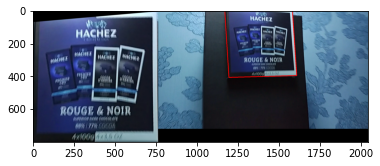

In [4]:
# check for one image
img = cv2.imread('tmp\clip_44.jpg')
res = orb_process_flann(img)
plt.imshow(res)

In [5]:
process_video('video.mp4', orb_process_flann, 'orb_flann')

In [6]:
save_img2video('orb_flann', 'orb_flann.mp4')

# Lucas Kanade

In [11]:
master_img = cv2.imread('marker.jpg')
orb = cv2.ORB_create(2000, 1.2, 13)
kp_master, des_master = orb.detectAndCompute(master_img,None)

def orb_process_flann(img):
    secondary_img = img.copy()
    kp_secondary, des_secondary = orb.detectAndCompute(secondary_img,None)
    
    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_master, des_secondary, k=2)

    # As per Lowe's ratio test to filter good matches
    selected = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            selected.append(m)
            
    dst = None
    if len(selected) > 10:
        # Prepare source and destination points for homography search
        dst_pts = np.float32([kp_master[m.queryIdx].pt for m in selected]).reshape(-1, 1, 2)
        src_pts = np.float32([kp_secondary[m.trainIdx].pt for m in selected]).reshape(-1, 1, 2)

        # Find homography (h_matrix - homography matrix)
        h_matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 3.0)
        # inliers
        matchesMask = mask.ravel()
        inliers = src_pts[mask]
        
        #dst = cv2.perspectiveTransform(dst_pts, h_matrix)
        img = master_img
        h_inv = np.linalg.inv(h_matrix)
        #warped = cv2.warpPerspective(secondary_img, h_inv, dsize=(img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        # draw rectangle
        h,w,d = master_img.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, h_matrix)
        homography = cv2.polylines(secondary_img, [np.int32(dst)], True, (255, 0, 0), 3)
        res_img = homography
        #res_img = merge_imgs(warped, homography)
        
    else:
        res_img = merge_imgs(master_img, secondary_img)
        r, c, _ = master_img.shape
        res_img[0:r, 0:c] = 0
    return res_img, dst

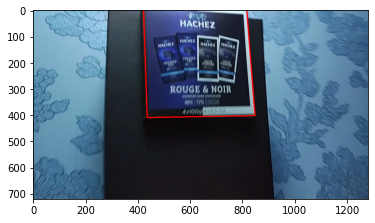

In [12]:
# check for one image
img = cv2.imread('tmp\clip_44.jpg')
res, dst = orb_process_flann(img)
plt.imshow(res)

In [22]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

MIN_POINT_TO_TRACK = 4

def orb_process_flann_step(frame, old_area):
    good_point_to_track = None
    new_area = 0
    frame, p0 = orb_process_flann(frame)
    if not(p0 is None):
        if(len(p0) >= MIN_POINT_TO_TRACK):
            p = cv2.convexHull(p0)
            new_area = cv2.contourArea(p)
            if(old_area == 0) or ((new_area > 0.5 * old_area) and (new_area < 2 * old_area)): # area is ok
                good_point_to_track = p0
    return frame, new_area, good_point_to_track

def lucas_kanade_method(video_path, dst_folder):
    # Read the video 
    cap = cv2.VideoCapture(video_path)

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(35, 35),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    # Create random colors
    color = np.random.randint(0, 255, (1000, 3))
    
    good_point_to_track = None
    old_area = 0
    i = 0
    while(cap.isOpened()):
        # Read new frame
        ret, frame = cap.read()
        if ret == True:
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            new_area = 0
            
            if(good_point_to_track is None):
                frame, new_area, good_point_to_track = orb_process_flann_step(frame, old_area)
            else:
                p0 = good_point_to_track.reshape(-1, 1, 2)
                # Calculate Optical Flow
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, curr_gray, p0, None, **lk_params)
                # Select good points
                good_new = p1[st == 1]
                good_old = p0[st == 1]
                
                is_track_found = False
                
                if(len(good_new) >= MIN_POINT_TO_TRACK):
                    p = cv2.convexHull(p1)
                    new_area = cv2.contourArea(p)
                    if(old_area == 0) or ((new_area > 0.5 * old_area) and (new_area < 2 * old_area)): # area is ok
                        is_track_found = True
                        good_point_to_track = good_new
                        # Draw rectangle & tracks
                        
                        frame = cv2.polylines(frame, [np.int32(p)], True, (255, 0, 0), 3)

                        # Draw the tracks
                        for j, (new, old) in enumerate(zip(good_new, good_old)):
                            a, b = new.ravel()
                            c, d = old.ravel()
                            a = int(a); b = int(b); c = int(c); d = int(d)
                            #mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
                            frame = cv2.circle(frame, (a, b), 5, color[j].tolist(), -1)
                            
                if not is_track_found:
                    frame, new_area, good_point_to_track = orb_process_flann_step(frame, old_area)
                    
                               
            # Update the previous frame and previous points
            old_gray = curr_gray.copy()
            old_area = new_area
            
            # Save frame into image file
            s = ""
            if(i < 10):
                s = "00"
            elif(i < 100):
                s = "0"
            cv2.imwrite('res\\' + dst_folder + '\\kang_'+ s +str(i)+'.jpg',frame)
            i = i + 1
            if(i %100 == 0):
                print(i)
            
            #cv2.imshow("frame", frame)
            # Press Q on keyboard to  exit
            #if cv2.waitKey(25) & 0xFF == ord('q'):
            #    break

            
        else: 
            break
            
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()


In [23]:
lucas_kanade_method('video.mp4', 'optical_flow')

100
200
300
400
500
600
700
800
900


In [24]:
save_img2video('optical_flow', 'optical_flow.mp4')